# Galaxy and Non-Galaxy Classifiers:
This code contains the following three models:

- Three classifier models including CNN-Vision Transformer, ResNet50, VGG16 have investigated to work the information of original galaxy and non-galaxy images.

This code is using code from the paper Galaxy Morphological Classification with Zernike Moments and Machine Learning Approaches by Ghaderi et al.

We will try to improve these codes by adaptions to the architecture and hyperparameter tuning. Every model is introduced by a heading stating the model name, adaptions made are given below the heading: "trial improvement" for that specific code.

This will be the structure: First the original code and than trial for improvements in big. And then onto the next model.

From each of the results the ROC curve is plotted, some metric values and the test accuracy and train accuracy.

### Import libraries:

The list of requried libraries are sklearn, pandas, numpy, tensorflow, matplotlib, etc.

## Three classifier models based on the original images:
  
- (Vision Transformer used as data augmentation tool on the Galaxy and Non-Galaxy images.)

### Import the requried libraries:

In [ ]:
# import packages

import cv2
import os
import numpy as np
import random
from PIL import Image
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

#Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Input,Conv2D, Flatten,
                             MaxPooling2D,BatchNormalization)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, VGG16
from keras.callbacks import EarlyStopping

#Torch
import torch
import torch.nn as nn
from torchvision import transforms

- To read the images of each class and convert to Pillow images we used the following function:

In [ ]:
def load_galaxy_images(data_dir, target_size):

        """
        Loads, resizes, and processes all JPG images from the specified directory.

        Parameters:
        data_dir (str): The directory containing the JPG images to be processed.
        target_size (tuple): The target size for resizing the images, specified as (width, height).

        Returns:
        list: A list of PIL Image objects, each representing a resized and processed image.

        The function performs the following steps:
        1. Lists all JPG image files in the specified directory.
        2. Reads each image using OpenCV.
        3. Resizes each image to the specified target size.
        4. Scales the pixel values and converts the image to a format compatible with PIL.
        5. Converts each resized image to a PIL Image object.
        6. Appends each PIL Image object to a list.
        7. Returns the list of PIL Image objects.
        """

        all_images = []

        file_path = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        for img in file_path:
            image = cv2.imread(img)
            resized_images=cv2.resize(image, target_size)
            resized_images = (resized_images * 255).astype(np.uint8)
            pil_images = Image.fromarray(resized_images)
            all_images.append(pil_images)

        return all_images

- Please use these directories from the repository for image data:
        
        - galaxy: /repository/Data/galaxy_nongalaxy/image/galaxy
        - non-galaxy: /repository/Data/galaxy_nongalaxy/image/nongalaxy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nongalaxy_path = r'/content/drive/Shared drives/DLP Project/Backup Project/Data/galaxy_nongalaxy/images/nongalaxy'
galaxy_path = r'/content/drive/Shared drives/DLP Project/Backup Project/Data/galaxy_nongalaxy/images/galaxy'

image_size = 200

g_img = load_galaxy_images(galaxy_path, target_size=(image_size,image_size))
ng_img = load_galaxy_images(nongalaxy_path, target_size=(image_size,image_size))

all_data = g_img + ng_img
np.shape(all_data)

(1335, 200, 200, 3)

- We define the **vision transformer** for both training and testing data sets:

In [ ]:
# transforms for training data
train_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])


# transforms for test data
test_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

- We use **"0"** for galaxy class labels and **"1"** for non-galaxy class labels.  

In [ ]:
galaxy_labels = np.zeros(len(g_img))
nongalaxy_labels = np.ones(len(ng_img))

all_labels = np.concatenate([galaxy_labels, nongalaxy_labels])
len(all_labels)

1335

### **CNN + vision transformer + original images**

- We split the data set into 75 percent traning set and 25 percent test set:

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=2)

- We apply the vision transformer for both training and testing samples:

In [ ]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

- Since, the galaxy and non-galaxy classifiers are unbalance class models, so we used the class weight in the program:

In [ ]:
class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

- The structure of the classic CNN model:

In [ ]:
# input
x = Input(shape=(image_size,image_size,3))

#hidden layers
c0 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding="same")(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling2D(pool_size=(2, 2))(b0)
d0 = Dropout(0.1)(m0)

c1 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same")(m0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling2D(pool_size=(2, 2))(b1)
d1 = Dropout(0.1)(m1)

c2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")(m1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling2D(pool_size=(2, 2))(b2)
d2 = Dropout(0.1)(m2)

f = Flatten()(m2)

# output layers
de0 = Dense(64, activation='relu')(f)
de1 = Dense(32, activation='relu')(de0)
de2 = Dense(2, activation='softmax')(de1)

model = Model(inputs=x, outputs=de2, name="cnn_transformer_galaxy_nonegalaxy")
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "cnn_transformer_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 200, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 200, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,560,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,940,002 (11.22 MB)

 Trainable params: 2,939,106 (11.21 MB)

 Non-trainable params: 896 (3.50 KB)

- The **CNN** model uses EarlyStopping as callback function, batch size = 64, and number of epochs = 30 to fit the model on the training set:

In [ ]:
# Callback Functions
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

b_size = 64
e_num = 30

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
class_weight=class_weights,
callbacks=es,
validation_split=0.1
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6331 - loss: 2.4819 - val_accuracy: 0.5842 - val_loss: 23.7682
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step - accuracy: 0.6418 - loss: 0.6613 - val_accuracy: 0.6139 - val_loss: 5.5152
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step - accuracy: 0.7715 - loss: 0.5109 - val_accuracy: 0.5248 - val_loss: 1.5136
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - accuracy: 0.7692 - loss: 0.4931 - val_accuracy: 0.7624 - val_loss: 0.5867
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - accuracy: 0.7981 - loss: 0.4709 - val_accuracy: 0.5248 - val_loss: 1.5561
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.7662 - loss: 0.4731 - val_accuracy: 0.6733 - val_loss: 0.8701
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 411ms/step - accuracy: 0.7657 - loss: 0.5247 - val_accuracy: 0.6337 - val_loss: 0.7239
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.7805 - loss: 0.4435 - val_accuracy:

- Now, we apply the test set to examine the classification algorithm. Using the predicted label by the machine on original labels, we compute the elements of the confusion matrix.

In [ ]:
# Plotting the learning curve
def plot_model_history(history):
    """Plot the training and validation history for a TensorFlow network"""

    # Extract loss and accuracy
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    n_epochs = len(loss)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=120)
    ax[0].plot(np.arange(n_epochs), loss, label="Training")
    ax[0].plot(np.arange(n_epochs), val_loss, label="Validation")
    ax[0].legend()
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")

    ax[1].plot(np.arange(n_epochs), acc, label="Training")
    ax[1].plot(np.arange(n_epochs), val_acc, label="Validation")
    ax[1].legend()
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")

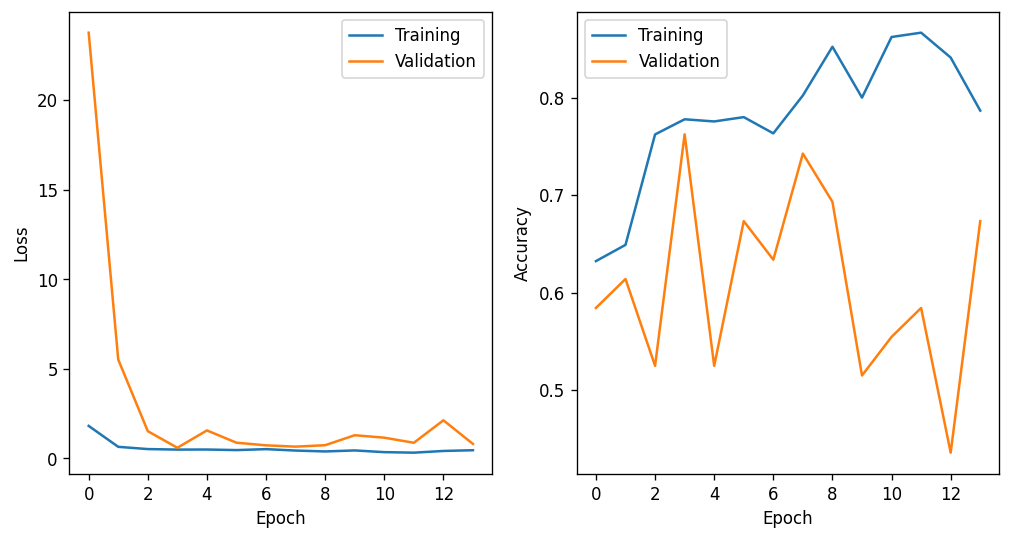

In [ ]:
plot_model_history(history)

In [ ]:
from sklearn import metrics
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

con = metrics.confusion_matrix(y_test, y_pred_labels)
print(con)

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step
[[176  26]
 [ 38  94]]


- To compare the performace of classifier with the random classifier, we calculate the **reciver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates of the classifier.

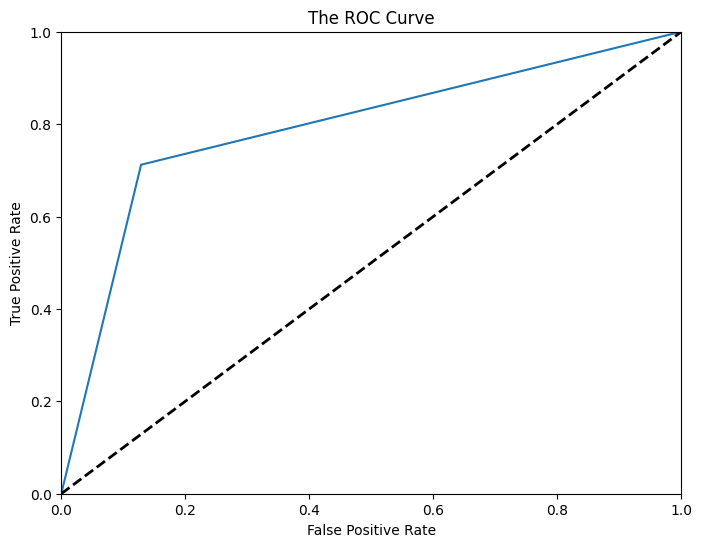

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_labels)
auc = metrics.roc_auc_score(y_test, y_pred_labels)

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.show()

- To measure the performance metrics of classifier, we compute **(Recall, Precision, f1_score, Accuracy, TSS(True Skill Statistic))**

In [ ]:
#Import packages

import os
from sklearn.svm import SVC
from sklearn import metrics
import pickle
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import (Dense, Dropout,BatchNormalization, Input, Conv1D, Flatten,
                             MaxPooling1D)
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


#Scikit_learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, auc, log_loss,
                             precision_score, recall_score, f1_score,
                             accuracy_score, classification_report,
                             ConfusionMatrixDisplay, confusion_matrix)

In [ ]:
import numpy as np

# Convert list to NumPy array
transformed_X_test = np.array(transformed_X_test, dtype=np.float32)

transformed_X_test = transformed_X_test.reshape(-1, image_size, image_size, 3)


<class 'list'>
334
<class 'torch.Tensor'>


In [ ]:
auc = metrics.roc_auc_score(y_test, y_pred_labels)

recall = recall_score(y_test, y_pred_labels, average= 'weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))


In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.8083832335329342
Precision: 0.8069785662320219
F1_score: 0.8065846329319383
Accuracy: 0.8083832335329342
TSS: 0.5834083408340834
AUC: 0.7917041704170418


# Trying to improve this model:
Changing:
  - added  L2 regularization to the layers to help reduce overfitting
  - learning rate scheuler with  ReduceLROnPlateau

  The following model is the 2D-CNN using vision transformer and original images. The improvements for this code in the network architecture: Increased dropout, adding L2 regularization in convolutional and dense layers, Batch normalization after every convolution for stable learning. The training improvements are: Learning rate scheduler, Increase of training epochs from 30 to 50.


In [ ]:
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

# Model with L2 Regularization and increased dropout
x = Input(shape=(image_size, image_size, 3))

c0 = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling2D(pool_size=(2, 2))(b0)
d0 = Dropout(0.3)(m0)  # Increased dropout

c1 = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="same")(d0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling2D(pool_size=(2, 2))(b1)
d1 = Dropout(0.3)(m1)

c2 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same")(d1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling2D(pool_size=(2, 2))(b2)
d2 = Dropout(0.3)(m2)

f = Flatten()(d2)

de0 = Dense(64, activation='relu')(f)
de1 = Dense(32, activation='relu')(de0)
de2 = Dense(2, activation='softmax')(de1)

model = Model(inputs=x, outputs=de2, name="cnn_transformer_galaxy_nonegalaxy")

# Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = Adam(learning_rate=0.001)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the Model
history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    batch_size=64,
    epochs=50,
    class_weight=class_weights,
    validation_split=0.1,
    callbacks=[es, lr_scheduler, checkpoint],
    verbose=1
)

# Make Predictions
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute and print metrics
conf_matrix = confusion_matrix(y_test, y_pred_labels)
fpr, tpr, _ = roc_curve(y_test, y_pred_labels)
auc = roc_auc_score(y_test, y_pred_labels)

print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC: {auc:.3f}")

# Recall, Precision, F1, Accuracy
recall = recall_score(y_test, y_pred_labels, average='weighted')
precision = precision_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

print(f"Recall: {recall:.3f}, Precision: {precision:.3f}, F1 Score: {f1:.3f}, Accuracy: {accuracy:.3f}")


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.5783 - loss: 6.2784
Epoch 1: val_loss improved from inf to 24.52842, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 778ms/step - accuracy: 0.5813 - loss: 6.1125 - val_accuracy: 0.6535 - val_loss: 24.5284 - learning_rate: 0.0010
Epoch 2/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.6968 - loss: 0.7989
Epoch 2: val_loss improved from 24.52842 to 5.92238, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 438ms/step - accuracy: 0.7007 - loss: 0.7892 - val_accuracy: 0.6040 - val_loss: 5.9224 - learning_rate: 0.0010
Epoch 3/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.6718 - loss: 0.7889
Epoch 3: val_loss improved from 5.92238 to 5.75224, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - accuracy: 0.6747 - loss: 0.7835 - val_accuracy: 0.6139 - val_loss: 5.7522 - learning_rate: 0.0010
Epoch 4/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7893 - loss: 0.5322
Epoch 4: val_loss improved from 5.75224 to 4.25985, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 442ms/step - accuracy: 0.7880 - loss: 0.5308 - val_accuracy: 0.6139 - val_loss: 4.2599 - learning_rate: 0.0010
Epoch 5/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6754 - loss: 1.8638
Epoch 5: val_loss improved from 4.25985 to 2.33506, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.6778 - loss: 1.7930 - val_accuracy: 0.4653 - val_loss: 2.3351 - learning_rate: 0.0010
Epoch 6/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.7219 - loss: 0.6142
Epoch 6: val_loss improved from 2.33506 to 0.75080, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 452ms/step - accuracy: 0.7253 - loss: 0.6122 - val_accuracy: 0.6931 - val_loss: 0.7508 - learning_rate: 0.0010
Epoch 7/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7803 - loss: 0.5645
Epoch 7: val_loss did not improve from 0.75080
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - accuracy: 0.7817 - loss: 0.5595 - val_accuracy: 0.6733 - val_loss: 1.2188 - learning_rate: 0.0010
Epoch 8/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6862 - loss: 1.3877
Epoch 8: val_loss did not improve from 0.75080
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step - accuracy: 0.6863 - loss: 1.3671 - val_accuracy: 0.6931 - val_loss: 0.7984 - learning_rate: 0.0010
Epoch 9/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.7741 - loss: 0.5821
Epoch 9: val_loss improved from 0.75080 to 0.59398, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step - accuracy: 0.7742 - loss: 0.5832 - val_accuracy: 0.7327 - val_loss: 0.5940 - learning_rate: 0.0010
Epoch 10/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.7985 - loss: 0.4959
Epoch 10: val_loss improved from 0.59398 to 0.56843, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - accuracy: 0.7954 - loss: 0.5010 - val_accuracy: 0.7822 - val_loss: 0.5684 - learning_rate: 0.0010
Epoch 11/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8175 - loss: 0.4141
Epoch 11: val_loss did not improve from 0.56843
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - accuracy: 0.8181 - loss: 0.4101 - val_accuracy: 0.6931 - val_loss: 0.6732 - learning_rate: 0.0010
Epoch 12/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8675 - loss: 0.3185
Epoch 12: val_loss did not improve from 0.56843
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - accuracy: 0.8685 - loss: 0.3173 - val_accuracy: 0.5743 - val_loss: 0.9363 - learning_rate: 0.0010
Epoch 13/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8324 - loss: 0.3719
Epoch 13: val_loss improved from 0.56843 to 0.50125, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - accuracy: 0.8328 - loss: 0.3732 - val_accuracy: 0.7426 - val_loss: 0.5013 - learning_rate: 0.0010
Epoch 14/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8329 - loss: 0.3530
Epoch 14: val_loss did not improve from 0.50125
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - accuracy: 0.8327 - loss: 0.3532 - val_accuracy: 0.7030 - val_loss: 0.7884 - learning_rate: 0.0010
Epoch 15/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.7901 - loss: 0.5449
Epoch 15: val_loss did not improve from 0.50125
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - accuracy: 0.7902 - loss: 0.5390 - val_accuracy: 0.7228 - val_loss: 0.6825 - learning_rate: 0.0010
Epoch 16/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8534 - loss: 0.3329
Epoch 16: val_loss did not improve from 0.50125
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - accuracy: 0.8512 - loss: 0.3370 - val_accuracy: 0.7426 - val_loss: 0.5701 - learning_rate: 0.0010
Epoch 17/50
14/15 ━━━━━━━━━━

In [ ]:
# Metrics calculation
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_labels)
auc = metrics.roc_auc_score(y_test, y_pred_labels)
precision = metrics.precision_score(y_test, y_pred_labels, average='weighted')
recall = metrics.recall_score(y_test, y_pred_labels, average='weighted')
f1 = metrics.f1_score(y_test, y_pred_labels, average='weighted')
accuracy = metrics.accuracy_score(y_test, y_pred_labels)


# Print metrics
tn, fp, fn, tp = conf_matrix.ravel()
tss = (tp / (tp + fn)) - (fp / (fp + tn))

print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"TSS: {tss:.3f}")
print(f"AUC: {auc:.3f}")

Recall: 0.763
Precision: 0.781
F1 Score: 0.747
Accuracy: 0.763
TSS: 0.433
AUC: 0.717


In [ ]:
# Final training loss and accuracy
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]

# Final validation loss and accuracy
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Print the final results
print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Loss: 0.19701218605041504
Final Training Accuracy: 0.9344444274902344
Final Validation Loss: 0.6023802161216736
Final Validation Accuracy: 0.7821782231330872


In [ ]:
from tensorflow.keras.utils import to_categorical
y_test_encoded = to_categorical(y_test, num_classes=2)
y_train_encoded = to_categorical(y_train, num_classes=2)
# Compute test accuracy and test loss using Keras' evaluate() method
test_loss, test_accuracy = model.evaluate(np.array(transformed_X_test), y_test_encoded, verbose=0)

# Compute training accuracy and training loss using Keras' evaluate() method
train_loss, train_accuracy = model.evaluate(np.array(transformed_X_train), y_train_encoded, verbose=0)

# Print training vs test performance
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")


Training Loss: 0.244, Training Accuracy: 0.927
Test Loss: 1.379, Test Accuracy: 0.763


### **ResNet50 + vision transformer + original images**

- We use **"0"** for galaxy class labels and **"1"** for non-galaxy class labels.  

In [ ]:
galaxy_labels = np.zeros(len(g_img))
nongalaxy_labels = np.ones(len(ng_img))

all_labels = np.concatenate([galaxy_labels, nongalaxy_labels])
len(all_labels)

1335

- We split the data set into 75 percent traning set and 25 percent test set:

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=2)

- We apply the vision transformer for both training and testing samples:

In [ ]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

- Since, the galaxy and non-galaxy classifiers are unbalance class models, so we used the class weight in the program:

In [ ]:
class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

- The **ResNet50** model uses EarlyStopping as callback function, batch size = 64, and number of epochs = 30 to fit the model on the training set:

In [ ]:
# Defining the pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)  # The custom layers
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
callbacks=es,
class_weight=class_weights,
validation_split=0.1
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.4972 - loss: 9.6966 - val_accuracy: 0.4257 - val_loss: 9702.1650
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 518ms/step - accuracy: 0.7740 - loss: 0.5321 - val_accuracy: 0.4257 - val_loss: 807.4796
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 537ms/step - accuracy: 0.8447 - loss: 0.3849 - val_accuracy: 0.4257 - val_loss: 175.1411
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 546ms/step - accuracy: 0.8870 - loss: 0.2758 - val_accuracy: 0.4257 - val_loss: 38.6183
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 534ms/step - accuracy: 0.9111 - loss: 0.1962 - val_accuracy: 0.4257 - val_loss: 6.3558
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 526ms/step - accuracy: 0.9345 - loss: 0.2139 - val_accuracy: 0.4257 - val_loss: 155.0277
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 507ms/step - accuracy: 0.8177 - loss: 0.3991 - val_accuracy: 0.4257 - val_loss: 36.6202
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 10

- Now, we apply the test set to examine the classification algorithm. Using the predicted label by the machine on original labels, we compute the elements of the confusion matrix.

In [ ]:
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

con = metrics.confusion_matrix(y_test, y_pred_labels)
print(con)

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 629ms/step
[[  0 191]
 [  0 143]]


- To compare the performace of classifier with the random classifier, we calculate the **reciver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates of the classifier.

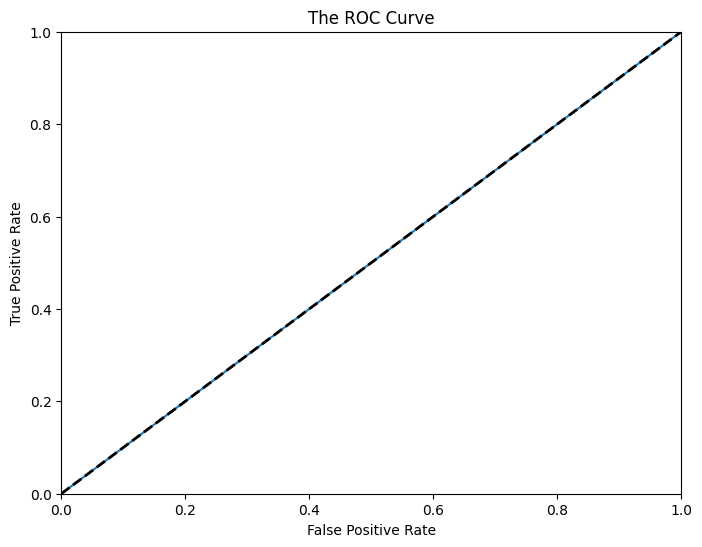

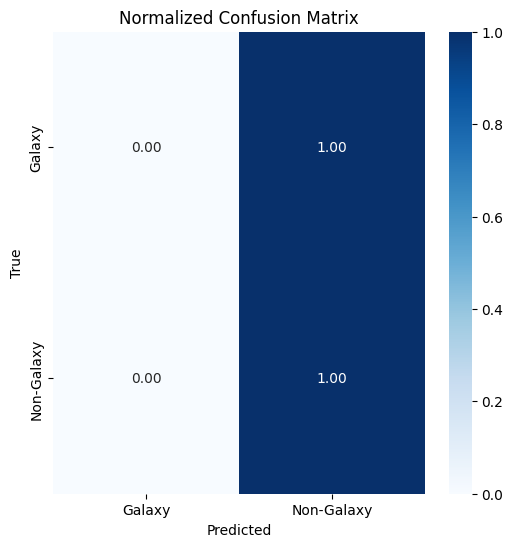

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_labels)
auc = metrics.roc_auc_score(y_test, y_pred_labels)

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.show()

# Plot confusion matrix
# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred_labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

class_names = ['Galaxy', 'Non-Galaxy']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

- To measure the performance metrics of classifier, we compute **(Recall, Precision, f1_score, Accuracy, TSS(True Skill Statistic))**

In [ ]:
recall = recall_score(y_test, y_pred_labels, average= 'weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.4281437125748503
Precision: 0.18330703861737602
F1_score: 0.25670671236144066
Accuracy: 0.4281437125748503
TSS: 0.0
AUC: 0.5


In [ ]:
# Final training loss and accuracy
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]

# Final validation loss and accuracy
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Print the final results
print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Loss: 0.1810363382101059
Final Training Accuracy: 0.9377777576446533
Final Validation Loss: 69.1242904663086
Final Validation Accuracy: 0.42574256658554077


In [ ]:
# Final training loss and accuracy
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]

# Final validation loss and accuracy
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Print the final results
print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Loss: 0.1810363382101059
Final Training Accuracy: 0.9377777576446533
Final Validation Loss: 69.1242904663086
Final Validation Accuracy: 0.42574256658554077


In [ ]:
# Compute test accuracy and test loss using Keras' evaluate() method
test_loss, test_accuracy = model.evaluate(np.array(transformed_X_test), y_test_encoded, verbose=0)

# Compute training accuracy and training loss using Keras' evaluate() method
train_loss, train_accuracy = model.evaluate(np.array(transformed_X_train), y_train_encoded, verbose=0)

# Print training vs test performance
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")


Training Loss: 69.562, Training Accuracy: 0.412
Test Loss: 72.660, Test Accuracy: 0.395


# Trial improvement

- Adding patience
- Adding Lr scheduler

for ResNet50 with vision transformer and original images the following adaptations were applied. The original ResNet50 code was under performing, thus radical changes were applied. Going from a custom CNN to a pre-trained ResNet50 model as a basemodel. The adaptations also implements the freezing of all layers in the ResNet50 base model to avoid overfitting in the initial training phase. Allowing the model to focus on specific features. Additionally a learning rate scheduler and Early stopping are included.

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 867ms/step - accuracy: 0.5675 - loss: 7.3187 - val_accuracy: 0.7030 - val_loss: 0.7875 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7223 - loss: 0.7976 - val_accuracy: 0.4356 - val_loss: 0.9918 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.6806 - loss: 0.5785 - val_accuracy: 0.6337 - val_loss: 0.6499 - learning_rate: 0.0010
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.7758 - loss: 0.4437 - val_accuracy: 0.6931 - val_loss: 0.6608 - learning_rate: 0.0010
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.8724 - loss: 0.3097 - val_accuracy: 0.7426 - val_loss: 0.5059 - learning_rate: 0.0010
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.9610 - loss: 0.1990 - val_accuracy: 0.7624 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.9719 - loss: 0.1541 -

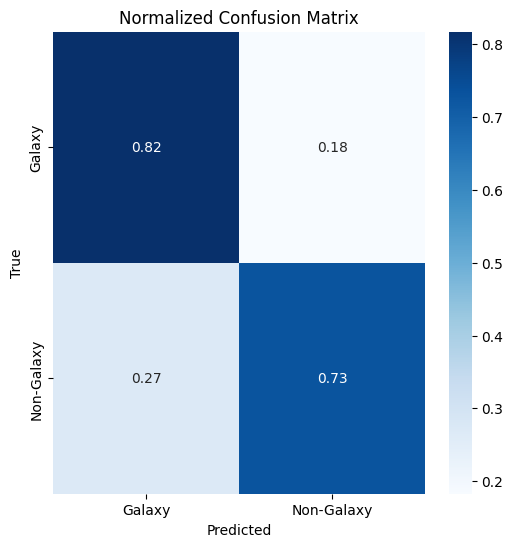

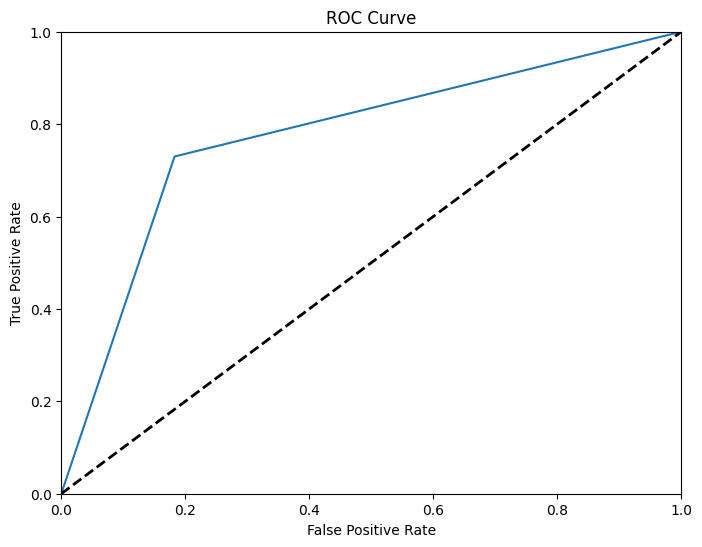

Recall: 0.781
Precision: 0.781
F1 Score: 0.781
Accuracy: 0.781
TSS: 0.547
AUC: 0.774


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the following data loaded
# X_train, X_test, y_train, y_test

# Convert labels to categorical
y_train_encoded = to_categorical(y_train, num_classes=2)


# Define class weights to handle class imbalance
class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

# Load ResNet50 as base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all layers in ResNet50 to avoid overfitting
for layer in base_model.layers:
    layer.trainable = False

# Build the custom model
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define EarlyStopping and LearningRate Scheduler
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
callbacks=[es, lr_scheduler],
class_weight=class_weights,
validation_split=0.1
)


# Evaluate the model
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred_labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
class_names = ['Galaxy', 'Non-Galaxy']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Metrics calculation
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_labels)
auc = metrics.roc_auc_score(y_test, y_pred_labels)
precision = metrics.precision_score(y_test, y_pred_labels, average='weighted')
recall = metrics.recall_score(y_test, y_pred_labels, average='weighted')
f1 = metrics.f1_score(y_test, y_pred_labels, average='weighted')
accuracy = metrics.accuracy_score(y_test, y_pred_labels)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print metrics
tn, fp, fn, tp = conf_matrix.ravel()
tss = (tp / (tp + fn)) - (fp / (fp + tn))

print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"TSS: {tss:.3f}")
print(f"AUC: {auc:.3f}")


In [ ]:
# Final training loss and accuracy
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]

# Final validation loss and accuracy
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Print the final results
print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Loss: 0.041842270642519
Final Training Accuracy: 0.9988889098167419
Final Validation Loss: 0.5543322563171387
Final Validation Accuracy: 0.7821782231330872


In [ ]:
# Compute test accuracy and test loss using Keras' evaluate() method
test_loss, test_accuracy = model.evaluate(np.array(transformed_X_test), y_test_encoded, verbose=0)

# Compute training accuracy and training loss using Keras' evaluate() method
train_loss, train_accuracy = model.evaluate(np.array(transformed_X_train), y_train_encoded, verbose=0)

# Print training vs test performance
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Training Loss: 0.149, Training Accuracy: 0.971
Test Loss: 0.547, Test Accuracy: 0.781
Recall: 0.781437125748503
Precision: 0.7812040802530412
F1_score: 0.7813134893101543
Accuracy: 0.781437125748503
TSS: 0.547185890548001
AUC: 0.7735929452740005


# Trial Resnext

Besides this improvement an extra model was included to see if it would obtain better performance compared to the ResNet models, utilizing ResNeXt. ResNext uses ResNet but adds cardinality, a number of parallel paths in each block. These grouped convolutions should improve efficiency and performance.



Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.5113 - loss: 1.2443 - val_accuracy: 0.6139 - val_loss: 0.6571 - learning_rate: 0.0010
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.5700 - loss: 0.6651 - val_accuracy: 0.6733 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.6028 - loss: 0.6744 - val_accuracy: 0.6139 - val_loss: 0.6333 - learning_rate: 0.0010
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.6371 - loss: 0.6337 - val_accuracy: 0.6931 - val_loss: 0.6157 - learning_rate: 0.0010
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.6808 - loss: 0.6045 - val_accuracy: 0.5941 - val_loss: 0.6488 - learning_rate: 0.0010
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.6778 - loss: 0.5873 - val_accuracy: 0.6535 - val_loss: 1.0702 - learning_rate: 0.0010
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7882 - loss: 0.466

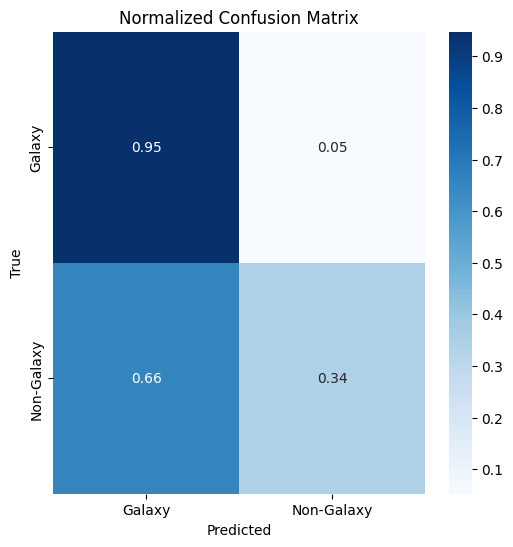

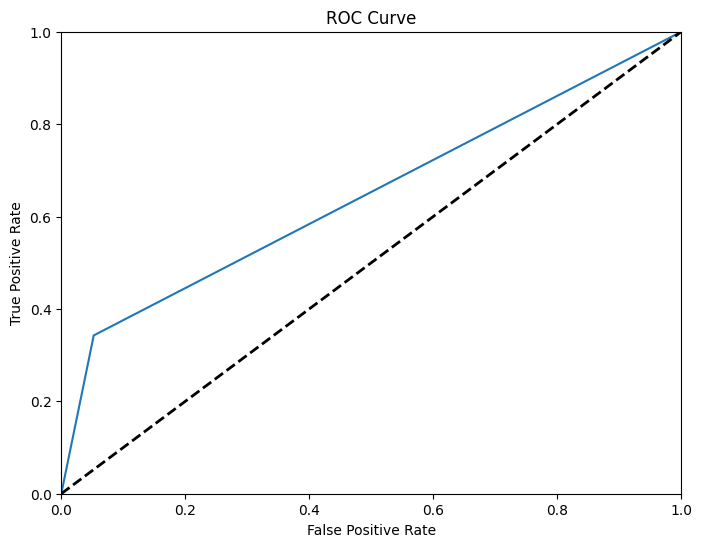

Recall: 0.689
Precision: 0.732
F1 Score: 0.652
Accuracy: 0.689
TSS: 0.290
AUC: 0.645


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Define the resnext block
class ResNeXtBlock(layers.Layer):
    def __init__(self, filters, cardinality, stride=1):
        super(ResNeXtBlock, self).__init__()
        self.cardinality = cardinality
        self.conv1x1_1 = layers.Conv2D(filters, kernel_size=1, padding='same')
        self.conv3x3 = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', groups=cardinality)
        self.conv1x1_2 = layers.Conv2D(filters, kernel_size=1, padding='same')
        self.bn = layers.BatchNormalization()

        # If the stride is greater than 1, we downsample the residual
        self.residual_conv = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')
        self.residual_bn = layers.BatchNormalization()

    def call(self, inputs):
        residual = inputs
        x = self.conv1x1_1(inputs)
        x = layers.ReLU()(x)
        x = self.conv3x3(x)
        x = layers.ReLU()(x)
        x = self.conv1x1_2(x)
        x = self.bn(x)

        # Downsample residual if needed
        residual = self.residual_conv(residual)
        residual = self.residual_bn(residual)

        return layers.add([x, residual])  # Adding the residual to the output



# resnext architecture
class ResNeXt(models.Model):
    def __init__(self, num_blocks, cardinality, num_classes=2):
        super(ResNeXt, self).__init__()
        self.conv1 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', input_shape=(None, None, 3))
        self.bn1 = layers.BatchNormalization()
        self.layer1 = self.make_layer(64, num_blocks[0], cardinality, stride=1)
        self.layer2 = self.make_layer(128, num_blocks[1], cardinality, stride=2)
        self.layer3 = self.make_layer(256, num_blocks[2], cardinality, stride=2)
        self.global_pool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def make_layer(self, filters, num_blocks, cardinality, stride):
        layers_list = []
        for _ in range(num_blocks):
            layers_list.append(ResNeXtBlock(filters, cardinality, stride))
        return models.Sequential(layers_list)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = layers.ReLU()(x)
        x = self.bn1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_pool(x)
        x = self.fc(x)
        return x

# Hyperparameters
num_blocks = [3, 4, 6]  # Number of blocks in each layer
cardinality = 8  # Cardinality (number of parallel paths in each group)

# Convert labels to categorical
y_train_encoded = to_categorical(y_train, num_classes=2)

# Define class weights to handle class imbalance
class_weights = {0: len(all_data) / (2 * len(g_img)), 1: len(all_data) / (2 * len(ng_img))}

# Initialize the ResNeXt model
model = ResNeXt(num_blocks=num_blocks, cardinality=cardinality, num_classes=2)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping and Learning Rate Scheduler
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model
history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    batch_size=16,
    epochs=e_num,
    verbose=1,
    callbacks=[es, lr_scheduler],
    class_weight=class_weights,
    validation_split=0.1
)

# Evaluate the model
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred_labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
class_names = ['Galaxy', 'Non-Galaxy']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Metrics calculation
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_labels)
auc = metrics.roc_auc_score(y_test, y_pred_labels)
precision = metrics.precision_score(y_test, y_pred_labels, average='weighted')
recall = metrics.recall_score(y_test, y_pred_labels, average='weighted')
f1 = metrics.f1_score(y_test, y_pred_labels, average='weighted')
accuracy = metrics.accuracy_score(y_test, y_pred_labels)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print metrics
tn, fp, fn, tp = conf_matrix.ravel()
tss = (tp / (tp + fn)) - (fp / (fp + tn))

print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"TSS: {tss:.3f}")
print(f"AUC: {auc:.3f}")


In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

Recall: 0.688622754491018
Precision: 0.7319623926261499
F1_score: 0.6519449945559949
Accuracy: 0.688622754491018
TSS: 0.2903013217149343
AUC: 0.6451506608574672


Resnext does not increase the accuracy over the other models, however it does return an improved accuracy compared to resnet. This is due to the "cardinality" group convolutions. These are parrallel paths. Instead of stacking more layers (like in ResNet), ResNeXt increases the cardinality of the network by using a split-transform-merge strategy, where each block in the network has multiple paths (called "group convolutions"). This allows the network to learn more diverse features, improving its ability to model complex data without increasing the number of parameters significantly.It should have an increased performance on large scale datasets.

### **VGG16 + vision transformer + original images**

- We use **"0"** for galaxy class labels and **"1"** for non-galaxy class labels.  

In [ ]:
galaxy_labels = np.zeros(len(g_img))
nongalaxy_labels = np.ones(len(ng_img))

all_labels = np.concatenate([galaxy_labels, nongalaxy_labels])
len(all_labels)

1335

- We split the data set into 75 percent traning set and 25 percent test set:

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=2)

- We apply the vision transformer for both training and testing samples:

In [ ]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

- Since, the galaxy and non-galaxy classifiers are unbalance class models, so we used the class weight in the program:

In [ ]:
class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

- The **VGG16** model uses EarlyStopping as callback function, batch size = 64, and number of epochs = 30 to fit the model on the training set:

In [ ]:
# Defining the pretrained ResNet50
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)  # The custom layers
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
callbacks=es,
class_weight=class_weights,
validation_split=0.1
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.4836 - loss: 12.1637 - val_accuracy: 0.5446 - val_loss: 0.6938
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 764ms/step - accuracy: 0.4987 - loss: 0.7169 - val_accuracy: 0.5941 - val_loss: 0.6372
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 789ms/step - accuracy: 0.5318 - loss: 0.7595 - val_accuracy: 0.6931 - val_loss: 0.6674
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 776ms/step - accuracy: 0.6084 - loss: 0.6381 - val_accuracy: 0.5743 - val_loss: 0.6643
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 758ms/step - accuracy: 0.6323 - loss: 0.6475 - val_accuracy: 0.7030 - val_loss: 0.6171
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 758ms/step - accuracy: 0.6603 - loss: 0.6197 - val_accuracy: 0.6634 - val_loss: 0.6113
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 786ms/step - accuracy: 0.7283 - loss: 0.5840 - val_accuracy: 0.4554 - val_loss: 1.0347
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 776ms

- Now, we apply the test set to examine the classification algorithm. Using the predicted label by the machine on original labels, we compute the elements of the confusion matrix.

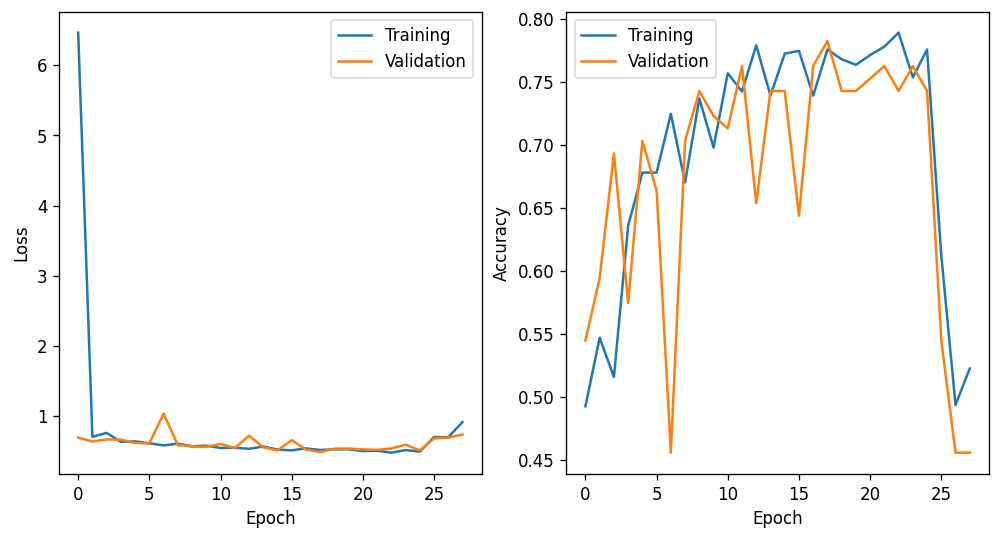

In [ ]:
plot_model_history(history)

In [ ]:
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

con = metrics.confusion_matrix(y_test, y_pred_labels)
print(con)

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 878ms/step
[[  0 204]
 [  0 130]]


- To compare the performace of classifier with the random classifier, we calculate the **reciver operation charecterstic curve (ROC curve)**. The **area under the curve (AUC)** shows the probability of True positive rates of the classifier.

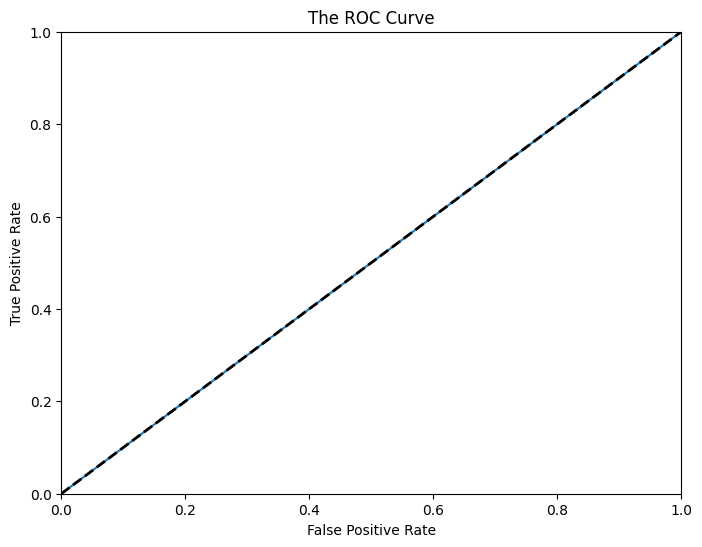

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_labels)
auc = metrics.roc_auc_score(y_test, y_pred_labels)

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.show()

- To measure the performance metrics of classifier, we compute **(Recall, Precision, f1_score, Accuracy, TSS(True Skill Statistic))**

In [ ]:
#recall = recall_score(y_test, y_pred, average= 'weighted')
#precision = precision_score(y_test, y_pred, average= 'weighted')
#f1_score = f1_score(y_test, y_pred, average= 'weighted')
#accuracy = accuracy_score(y_test, y_pred)

#tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
recall = recall_score(y_test, y_pred_labels, average= 'weighted')
precision = precision_score(y_test, y_pred_labels, average= 'weighted')
f1 = f1_score(y_test, y_pred_labels, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_labels).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))

In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)

# Evaluate Test Set
test_loss, test_acc = model.evaluate(np.array(transformed_X_test), to_categorical(y_test, num_classes=2))
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}")


Recall: 0.38922155688622756
Precision: 0.15149342034493887
F1_score: 0.21809828618624819
Accuracy: 0.38922155688622756
TSS: 0.0
AUC: 0.5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.3885 - loss: 0.7694
Test Loss: 0.769, Test Accuracy: 0.389


In [ ]:
# Final training loss and accuracy
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]

# Final validation loss and accuracy
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Print the final results
print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Loss: 0.9149998426437378
Final Training Accuracy: 0.5222222208976746
Final Validation Loss: 0.7375980019569397
Final Validation Accuracy: 0.4554455578327179


# Trial 2 improving:
- Adding batch normalization
- Adding dropout layers to prevent overfitting
- Increased neurons to 128
- Use learning rate schedules

The last model, VGG16 with vision transformer and utilizing original images is adapted with the following additions. Including batch normalization after after dense layers, Dropout layers, increased first dense layer of neurons from 64 to 128. An adjustment in learning rate, to a smaller learning rate of 1e-4 compared to the default Adam optimizer learning rate of of 0.001. The changed code also dynamically reduces the learning rate based on validation loss, improving convergence. The batch size is increased from 16 to 32 and the training epochs from 30 to 50. This all should help for a better performance in the model.


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 608ms/step - accuracy: 0.6140 - loss: 0.7914 - val_accuracy: 0.6040 - val_loss: 1.5721 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 453ms/step - accuracy: 0.6666 - loss: 0.6567 - val_accuracy: 0.6040 - val_loss: 3.4573 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - accuracy: 0.7080 - loss: 0.6036 - val_accuracy: 0.6040 - val_loss: 5.4296 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 450ms/step - accuracy: 0.8037 - loss: 0.4596 - val_accuracy: 0.6040 - val_loss: 4.5689 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy: 0.8174 - loss: 0.4395 - val_accuracy: 0.6238 - val_loss: 2.1223 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.7805 - loss: 0.4546
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - accuracy:

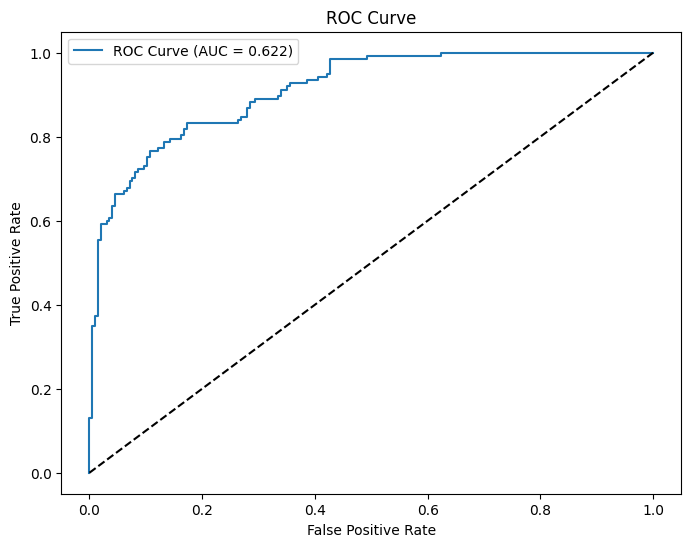

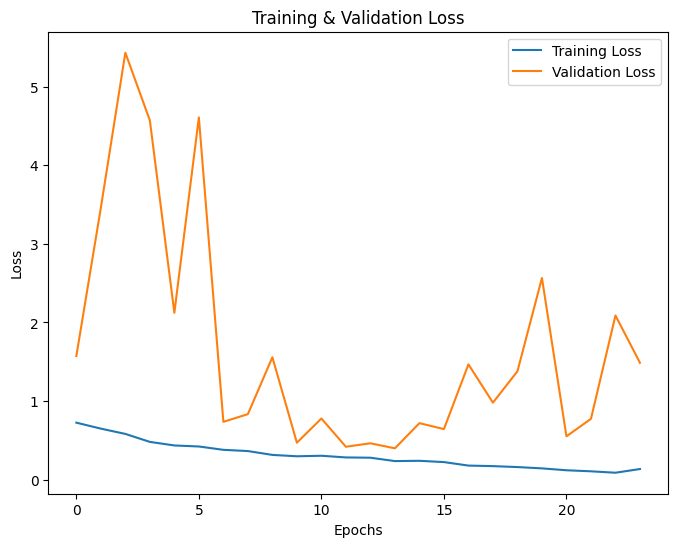

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score

# Load and preprocess labels
galaxy_labels = np.zeros(len(g_img))
nongalaxy_labels = np.ones(len(ng_img))
all_labels = np.concatenate([galaxy_labels, nongalaxy_labels])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.25, shuffle=True, random_state=42)

# One-hot encode labels
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

# Transform images
transformed_X_train = np.array([np.transpose(train_transform(img), (1, 2, 0)) for img in X_train])
transformed_X_test = np.array([np.transpose(test_transform(img), (1, 2, 0)) for img in X_test])

# Compute class weights
class_weights = {0: len(all_data) / (2 * len(g_img)), 1: len(all_data) / (2 * len(ng_img))}

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Reduce overfitting
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)#
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train model
history = model.fit(
    transformed_X_train, y_train_encoded,
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


y_pred = model.predict(transformed_X_test)
y_pred_labels = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Compute metrics
recall = recall_score(y_test, y_pred_labels, average='weighted')
precision = precision_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_test, y_pred_labels)
auc = roc_auc_score(y_test, y_pred_labels)

# Print results
print("Confusion Matrix:\n", conf_matrix)
print(f"Recall: {recall:.3f}, Precision: {precision:.3f}, F1-Score: {f1:.3f}, Accuracy: {accuracy:.3f}, AUC: {auc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Compute test accuracy and test loss using Keras' evaluate() method
test_loss, test_accuracy = model.evaluate(np.array(transformed_X_test), y_test_encoded, verbose=0)

# Compute training accuracy and training loss using Keras' evaluate() method
train_loss, train_accuracy = model.evaluate(np.array(transformed_X_train), y_train_encoded, verbose=0)

# Print training vs test performance
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")


Training Loss: 1.085, Training Accuracy: 0.504
Test Loss: 1.299, Test Accuracy: 0.554


In [ ]:
print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)


Recall: 0.5538922155688623
Precision: 0.7863050123529166
F1_score: 0.4968088428729457
Accuracy: 0.5538922155688623
TSS: 0.0
AUC: 0.6218274111675126
